---
layout:     post
title:      "Supreme Gridlock"
date:       2017-04-26 10:00:00
author:     Andrew
header-img: img/posts/supreme_court_seats/bench.jpg
header-credit: https://unsplash.com/@willpat
tags:       programming riddler politics puzzles
---

Last week I won the FiveThityEight [Riddler](https://fivethirtyeight.com/features/pick-a-card-any-card/)!  (don't get too excited, the winner is randomly selected 😉)

![winner]({{ site.baseurl }}/img/posts/supreme_court_seats/classic_winner.png)

I don't share every riddler I work on, but this one is straightforward yet interesting, politically applicable, and was fun to work on.

[Here is the riddle](https://fivethirtyeight.com/features/how-many-bingo-cards-are-there-in-the-world/):
> Imagine that U.S. Supreme Court nominees are only confirmed if the same party holds the presidency and the Senate. What is the expected number of vacancies on the bench in the long run?    
You can assume the following:
* You start with an empty, nine-person bench.
* There are two parties, and each has a 50 percent chance of winning the presidency and a 50 percent chance of winning the Senate in each election.
* The outcomes of Senate elections and presidential elections are independent.
* The length of time for which a justice serves is uniformly distributed between zero and 40 years.

Additional clarifications I made:
* President elected every 4 years, Senate every 2 years.
* Judicial terms will be integers (whole years), and if a judge leaves on an election year, the seat will be potentially filled by the incoming government.


*I have omitted some of the code for brevity.  Full code [here](https://github.com/andrewzwicky/puzzles/tree/master/FiveThirtyEightRiddler/2017-04-14)*

In [1]:
from enum import Enum
import itertools
import random
from collections import Counter
import numpy as np
from plotting import *
from multiprocessing import Pool
from tqdm import tqdm_notebook

%matplotlib inline

First we'll need a way to track which party the Senate & President are part of.  For now, let's just stick with the two major parties and create a `Party` [enumeration](https://en.wikipedia.org/wiki/Enumerated_type).  Enumerations can group and give names to related constants in the code.  This can help the code be more understandable when reading it.

In [2]:
class Party(Enum):
    D = 1
    R = 2
    
color_trans = {Party.D:'blue', Party.R:'red'}

We'll also make a class to represent each justice.  When a new `Justice` is created for a party, they'll be given a randomly generated term of somewhere between 0 and 40 years.

In [3]:
class Justice:
    
    def __init__(self, party):
        self.party = party
        self.term = random.randint(0,40)
        
        
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return "{party}-{term}".format(party=self.party.name,term=self.term)

Our lass class is `Bench`.  This class will represent the bench that contains the `Justices` currently on the Supreme Court.  When the `Bench` is first formed, it will be empty.  We care about modifying the `Bench` in a few ways:

1. Filling all available seats with judges of a certain party (`fill_seats`).
2. Adding years to determine if judges have vacated their seats (`add_years`).
3. Getting the composition of the court at a particular year, used for displaying the data later (`breakdown`).

Empty seats in the court are represented by `None`, and judges are removed when they have <= 0 years left in their term.

In [4]:
class Bench:
    
    SIZE = 9
    
    def __init__(self):
        self.seats = [None] * self.SIZE
    
    def fill_seats(self, party):
        # loop through all seats
        for i in range(self.SIZE):
            if self.seats[i] is None:
                # if seat is empty, add new 
                # justice of the correct party
                self.seats[i] = Justice(party)
                
    def add_years(self, num_years):
        for i in range(self.SIZE):
            if self.seats[i] is not None:
                # for occupied seats, remove the given
                # number of years from their remaining
                # term.  If their term is less than 0
                # this means their seat should now
                # be empty again.
                self.seats[i].term -= num_years
                if self.seats[i].term <= 0:
                    self.seats[i] = None
    
    def breakdown(self):
        c = Counter([s.party.name if s is not None else "" for s in self.seats])

        return tuple(c[k] if k in c else 0 for k in [""] + [e.name for e in Party])
    
    def __repr__(self):
        return "\n".join(map(str,self.seats))

Last but not least, `simulate` is where the magic happens.  This function loops over a supplied number of years, first determining if any judges have left their position.  After that, it randomly picks the winning parties for any elections that are happening.  After the elections, if the government is aligned, empty seats on the bench should be filled by that party.

In [5]:
def simulate(years):
    president_party = None
    senate_party = None
    bench = Bench()
        
    for year in range(years+1):
        bench.add_years(1)
        
        if year % 2 == 0:
            senate_party = random.choice(list(Party))
        
        if year % 4 == 0:
            president_party = random.choice(list(Party))
        
        if president_party == senate_party:
            bench.fill_seats(president_party)
        
        yield year, bench.breakdown(), president_party, senate_party

`run_simulation` will execute the simulation for the supplied number of years, and post-process the data to return the following information:    
`years`: an array of all the years that were simulated.    
`bench_stacks`: the stacked bar graph data for the composition of the court at each year.    
`president_parties`: an array of the president's party at each year.    
`senate_parties`: an array of the senate's party at each year.    
`mean`: an array with the [cumulative moving averages](https://en.wikipedia.org/wiki/Moving_average#Cumulative_moving_average) of the number of vacancies.

In [6]:
def run_simulation(sim_years):
    years, benches, president_parties, senate_parties = zip(*list(simulate(sim_years)))
    bench_stacks = np.row_stack(zip(*benches))
    vacancies = bench_stacks[0]
    mean = np.cumsum(vacancies) / (np.asarray(years) + 1)
    return years, bench_stacks, president_parties, senate_parties, mean

First, let's look at the result of our simulated supreme court over 200 years.  Along the bottom, the parties of the Senate and President are shown.  The height of each stack represents the number of seats that party holds, and the white space indicates vacancies.

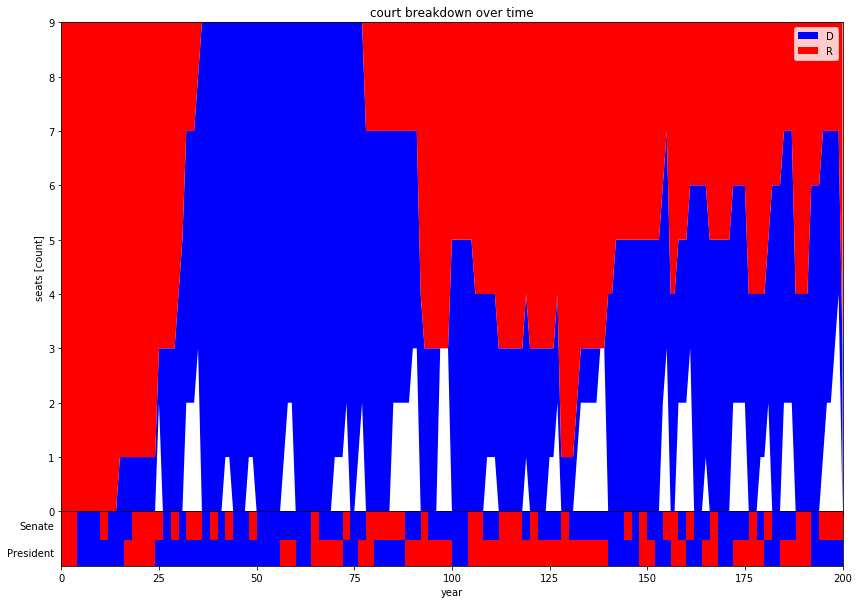

In [15]:
sim_years = 200

years, bench_stacks, president_parties, senate_parties, _ = run_simulation(sim_years)

stacked_plot_bench_over_time_with_parties(years,
                                          bench_stacks,
                                          president_parties,
                                          senate_parties,
                                          color_trans,
                                          Party)

During the periods of alignment, the vacancies (white spaces) as filled.  This just serves as visual confirmation that our simulation got that aspect correct.  We can see that seats are continuously being vacated and filled, so we can't learn much from just this one plot.

As an aside, it's difficult to look at this and not imagine potential storylines!  In the beginning, an initially 100% Republican court slowly retires over time.  In the mean time, the two parties fight for control of the Senate under continuous Democratic presidencies from years 25 to 50.

But enough of that, let's get back to the numbers.  Next, let's simulate over a longer time period, 1000 years, and view the cumulative average number of vacancies.

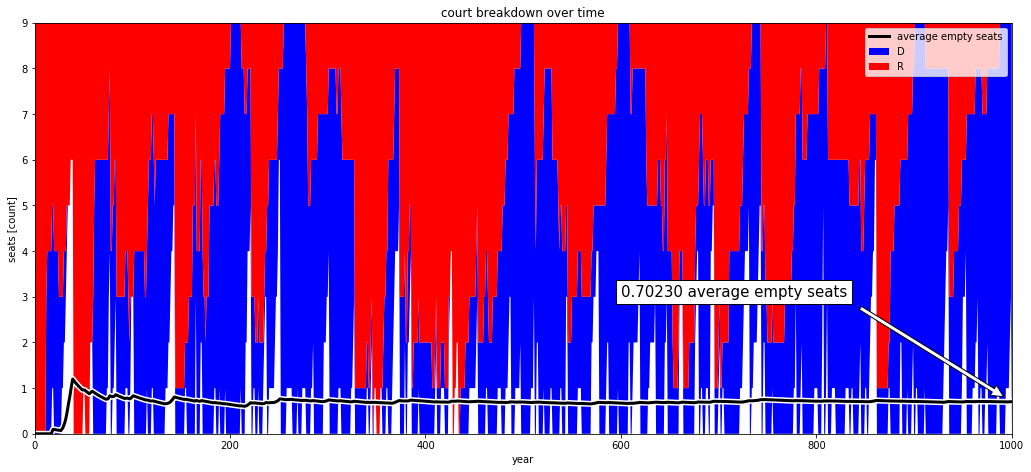

In [16]:
sim_years = 1000

years, bench_stacks, _, _, mean = run_simulation(sim_years)

stacked_plot_bench_over_time(years, bench_stacks, mean, color_trans, Party)

This simulation shows that we should expect a little less than 1 vacancy, about 0.7, per year.  It also illustrates that as more data is added, the cumulative moving average becomes less variable.

However, this is only a single simulation run, and could be an outlier.  To see how likely different numbers of vacancies are, let's run a [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) experiment.  In this experiment, we're going to run 1000 different simulations, each to 50000 years.

In [ ]:
sim_years = 50000
sample_size = 1000

results=[]

with Pool(processes=4) as p:
    with tqdm_notebook(total=sample_size) as pbar:
        for r in p.imap_unordered(run_simulation, itertools.repeat(sim_years,sample_size)):
            results.append(r)
            pbar.update(1)
    
years, _, _, _, means = zip(*results)

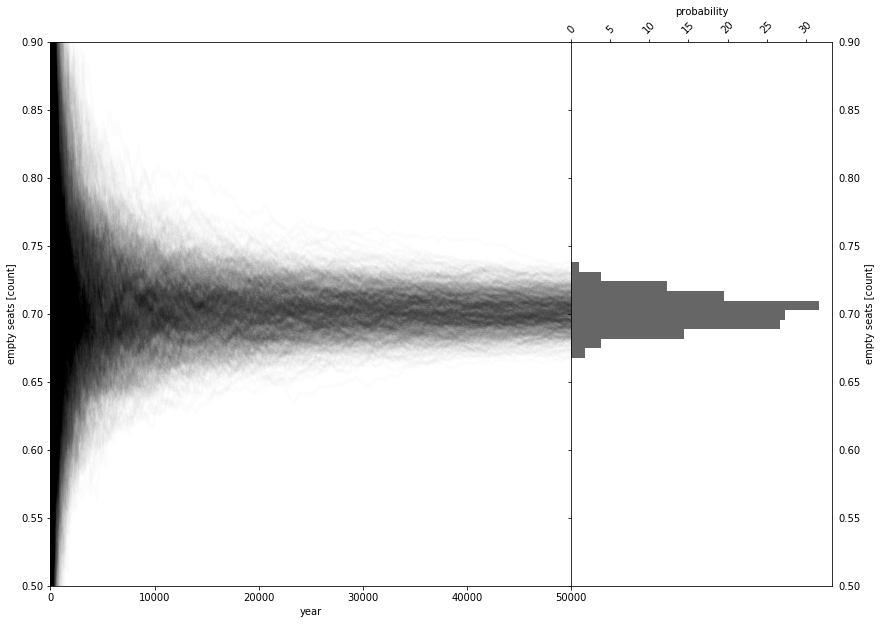

In [8]:
plot_sims(years[0], means, [0.5, 0.9])

This distribution shows that we should still expect to see **~0.71 vacancies per year over the long run**, but it wouldn't be surprising to see 0.68 or 0.73 vacancies.

As a thought experiment, let's see what happen if the Green Party suddenly launches into relevance and all 3 parties have an equal shot in elections.  How would this impact the result?

In [9]:
class Party(Enum):
    D = 1
    R = 2
    G = 3
    
color_trans = {Party.D:'blue', Party.R:'red', Party.G:'green'}

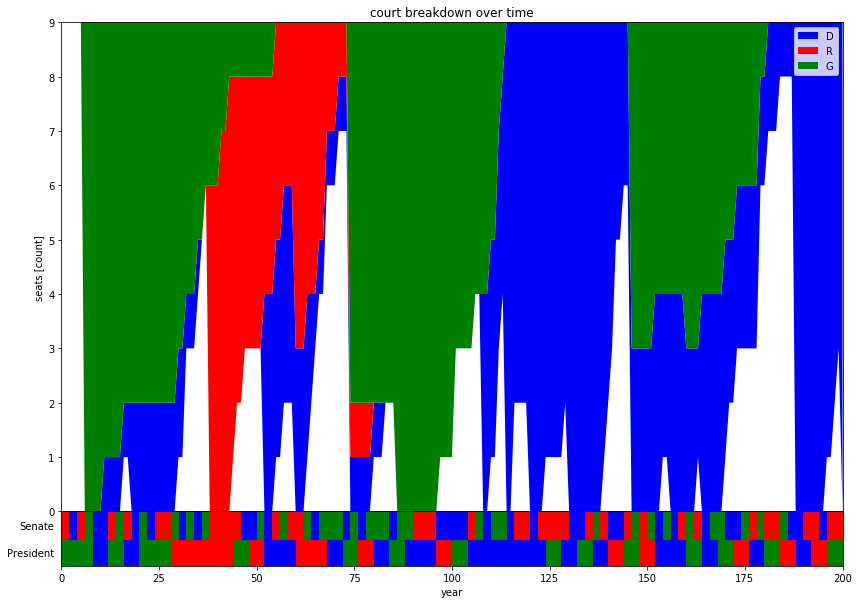

In [10]:
sim_years = 200

years, bench_stacks, president_parties, senate_parties, mean = run_simulation(sim_years)

stacked_plot_bench_over_time_with_parties(years,
                                          bench_stacks,
                                          president_parties,
                                          senate_parties,
                                          color_trans,
                                          Party)

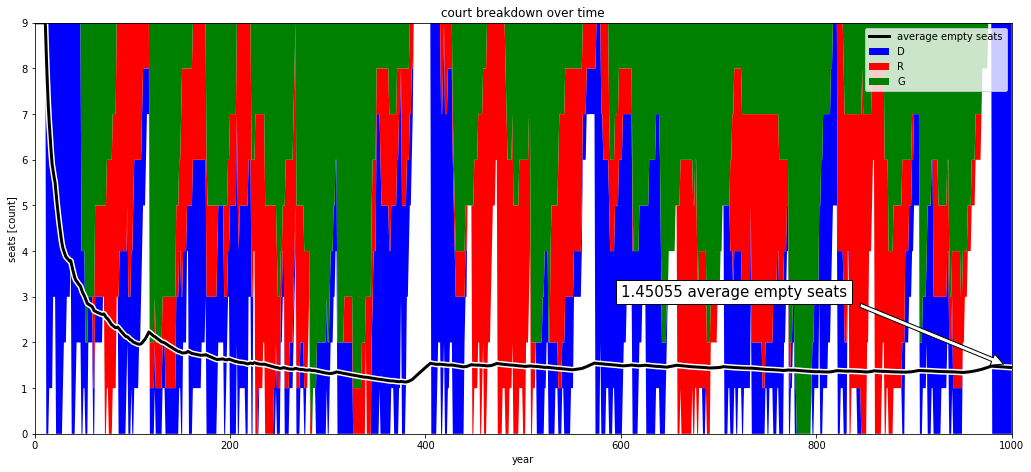

In [11]:
sim_years = 1000

years, bench_stacks, president_parties, senate_parties, mean = run_simulation(sim_years)

stacked_plot_bench_over_time(years, bench_stacks, mean, color_trans, Party)

Unsurprisingly, adding more parties into the mix while still requiring an aligned government looks like it leads to even more vacancies.  But, how do the numbers shake out?

In [ ]:
sim_years = 50000
sample_size = 1000

results=[]

with Pool(processes=4) as p:
    with tqdm_notebook(total=sample_size) as pbar:
        for r in p.imap_unordered(run_simulation, itertools.repeat(sim_years,sample_size)):
            results.append(r)
            pbar.update(1)
    
years, _, _, _, means = zip(*results)

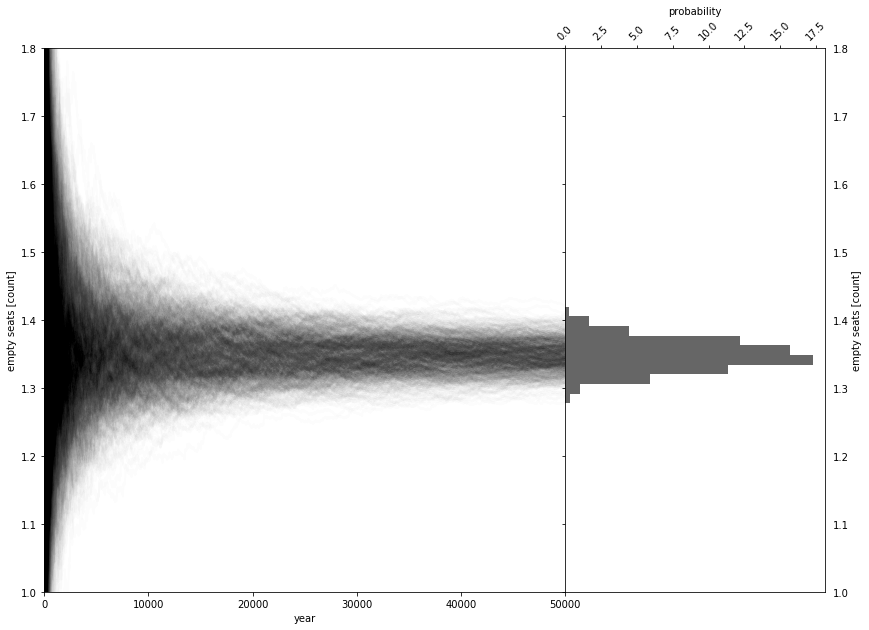

In [13]:
plot_sims(years[0], means, [1, 1.8])

It appears that under our theoretical three party government, we should expect **almost twice as many (~1.35 compared to ~0.71) vacancies in the long run!**

Well, I hope you enjoyed reading!  I've added some extra credit reading from others below that have analytical approaches to the riddle as well.

## Related Reading
[https://hectorpefo.github.io/2017-04-16-supreme-vacancies/](https://hectorpefo.github.io/2017-04-16-supreme-vacancies/)    
[http://www.laurentlessard.com/bookproofs/a-supreme-court-puzzle/](http://www.laurentlessard.com/bookproofs/a-supreme-court-puzzle/)